## Finishing Order Classification: Neural Network Model

This notebook contains the Neural Network Model used in the project: "Classifying the Field". The model is constructed by training 22 Neural Networks which independantly find the probability that a driver will finish in a given position. An algorithm then uses these probabilities to build the best model for the full finishing order. 

In addition to the model itself, this notebook also contains several different metrics evaluating the model's performance:

#### Table of Contents
* The Data Set
* The Neural Network Model
* Model Evaluation
* Output Visualization

#### Data Sources
* Historic Formula 1 Race Data from: https://www.kaggle.com/rohanrao/formula-1-world-championship-1950-2020
* Free Practice Data scrubbed from: https://www.formula1.com/en/results.html
* Real World Predictinos scrubbed from: https://backofthegrid.com/prediction-results

In [1]:
# Imports libraries
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.metrics import mean_squared_error

### The Data Set

In [38]:
# Imports 'results', 'races', and 'circuits' data as data frames
res = pd.read_csv('f1_archive/results.csv')
races = pd.read_csv('f1_archive/races.csv')
circ = pd.read_csv('f1_archive/circuits.csv')
wdc = pd.read_csv('f1_archive/driver_standings.csv')
wcc = pd.read_csv('f1_archive/constructor_standings.csv')
full_res = pd.read_csv('f1_archive/full_results_post_2014.csv')
drivers = pd.read_csv('f1_archive/drivers.csv')

races[races['raceId'] == 1053]

,raceId,year,round,circuitId,name,date,time,url
1035,1053,2021,2,21,Emilia Romagna Grand Prix,2021-04-18,13:00:00,http://en.wikipedia.org/wiki/2021_Emilia_Romag...


In [3]:
# Builds the data frame to be used in the classifier.
data = full_res.loc[:,['resultId', 'raceId', 'driverId', 'constructorId', 'positionOrder', 'fp1Pos', 'fp2Pos']]

data['code'] = ''
data['circuitId'] = ''
data['year'] = 0

for i in data.index:
        id = data.loc[i,'driverId']
        code = drivers[drivers['driverId'] == id]['code'].to_list()[0]
        raceId = data.loc[i,'raceId']
        circuitId = races[races['raceId'] == raceId]['circuitId'].to_list()[0]
        year = races[races['raceId'] == raceId]['year'].to_list()[0]
        data.loc[i,'code'] = code
        data.loc[i,'circuitId'] = circuitId
        data.loc[i,'year'] = year

# Defines a function to find the race ID of the previous race
def find_last(ID):
    row = races[races['raceId'] == ID].index
    year = races.loc[row, 'year'].to_list()[0]
    round = races.loc[row, 'round'].to_list()[0]

    if round == 1:
        year = year - 1
        round = races[races['year'] == year].loc[:,'round'].max()
    else:
        round = round - 1

    last_id = races[(races['year'] == year) & (races['round'] == round)]['raceId'].to_list()[0]
    #print(year, round)
    #print(last_id)
    return last_id

# Adds columns for lastPos, lastGrid, wdcPos, and wccPos
data['lastPos'] = np.nan
data['lastPos2'] = np.nan
data['lastPos3'] = np.nan
data['lastPos4'] = np.nan
data['lastPos5'] = np.nan
data['lastPos6'] = np.nan

data['lastGrid'] = np.nan
data['lastGrid2'] = np.nan
data['lastGrid3'] = np.nan

data['wdcPos'] = np.nan
data['wccPos'] = np.nan

data['experience'] = 0

for i in data.index:
    current_id = data.loc[i,'raceId']
    lastId = find_last(current_id)
    lastId2 = find_last(lastId)
    lastId3 = find_last(lastId2)
    lastId4 = find_last(lastId3)
    lastId5 = find_last(lastId4)
    lastId6 = find_last(lastId4)

    driverId = data.loc[i,'driverId']
    constructorId = data.loc[i,'constructorId']
    
    try:
        result = full_res[(full_res['raceId'] == lastId) & (full_res['driverId'] == driverId)]['positionOrder'].to_list()[0]
        data.loc[i,'lastPos'] = result
    except:
        pass
    
    try:
        result = full_res[(full_res['raceId'] == lastId2) & (full_res['driverId'] == driverId)]['positionOrder'].to_list()[0]
        data.loc[i,'lastPos2'] = result
    except:
        pass

    try:
        result = full_res[(full_res['raceId'] == lastId3) & (full_res['driverId'] == driverId)]['positionOrder'].to_list()[0]
        data.loc[i,'lastPos3'] = result
    except:
        pass

    try:
        result = full_res[(full_res['raceId'] == lastId4) & (full_res['driverId'] == driverId)]['positionOrder'].to_list()[0]
        data.loc[i,'lastPos4'] = result
    except:
        pass

    try:
        result = full_res[(full_res['raceId'] == lastId5) & (full_res['driverId'] == driverId)]['positionOrder'].to_list()[0]
        data.loc[i,'lastPos5'] = result
    except:
        pass

    try:
        result = full_res[(full_res['raceId'] == lastId6) & (full_res['driverId'] == driverId)]['positionOrder'].to_list()[0]
        data.loc[i,'lastPos6'] = result
    except:
        pass

    try:
        grid = full_res[(full_res['raceId'] == lastId) & (full_res['driverId'] == driverId)]['grid'].to_list()[0]
        data.loc[i,'lastGrid'] = grid
    except:
        pass

    try:
        grid = full_res[(full_res['raceId'] == lastId2) & (full_res['driverId'] == driverId)]['grid'].to_list()[0]
        data.loc[i,'lastGrid2'] = grid
    except:
        pass

    try:
        grid = full_res[(full_res['raceId'] == lastId3) & (full_res['driverId'] == driverId)]['grid'].to_list()[0]
        data.loc[i,'lastGrid3'] = grid
    except:
        pass

    try:
        wdc_pos = wdc[(wdc['raceId'] == lastId) & (wdc['driverId'] == driverId)]['position'].to_list()[0]
        data.loc[i,'wdcPos'] = wdc_pos
    except:
        pass

    try:
        wcc_pos = wcc[(wcc['raceId'] == lastId) & (wcc['constructorId'] == constructorId)]['position'].to_list()[0]
        data.loc[i,'wccPos'] = wcc_pos
    except:
        pass

    try:
        races_in = res[res['driverId'] == driverId]['raceId'].to_list()
        current_year = races[races['raceId'] == current_id]['year'].to_list()[0]
        experience = races[ (races['raceId'].isin(races_in)) & (races['year'] < current_year)].shape[0]
        data.loc[i,'experience'] = experience
    except:
        pass

# Handles wierd case in free practice data
for factors in ['fp1Pos', 'fp2Pos']:
    for i in data.index:
        if data.loc[i,factors] == -1:
            data.loc[i,factors] = np.nan
        else:
            pass

# Adds a column containing each drivers relative performance at each track
driver_list = data['driverId'].drop_duplicates().to_list()
race_list = data['raceId'].drop_duplicates().to_list()
track_list = data['circuitId'].drop_duplicates().to_list()

years_list = list(range(2010,2022))

# Builds a 3d matrix (list) containing the drivers performances at each circuit
cols = ['driverId', 'code', 'circuitId', 'name'] + years_list
matrix = pd.DataFrame(columns = cols)

for people in driver_list:

    for tracks in track_list:
        code = drivers.loc[drivers[drivers['driverId'] == people].index, 'code'].to_list()[0]
        circuit = circ.loc[circ[circ['circuitId'] == tracks].index, 'circuitRef'].to_list()[0]
        row = [people, code, tracks, circuit]
        
        for years in years_list:
            try:
                id = races[(races['year'] == years) & (races['circuitId'] == tracks)]['raceId'].to_list()[0]
                pos = res[(res['driverId'] == people) & (res['raceId'] == id)]['positionOrder'].to_list()[0]
            except:
                pos = np.nan
            
            row.append(pos)

        matrix.loc[matrix.shape[0]] = row

# Computes the relative performance of each driver at each circuit based on finishing position
def position_to_performance(x, mean, finishers):
    if x < mean:
        a = 2 ** (1 / (mean - 1))
        b = (a ** (mean - x)) -1
    else:
        a = 2 ** (1 / (mean - finishers))
        b = (-1 * (a ** (mean - x))) +1
    y = 0.5 + (0.5 * b)
    return y

performance_matrix = pd.DataFrame(columns= cols)

for people in driver_list:

    for tracks in track_list:
        code = drivers.loc[drivers[drivers['driverId'] == people].index, 'code'].to_list()[0]
        circuit = circ.loc[circ[circ['circuitId'] == tracks].index, 'circuitRef'].to_list()[0]
        row = [people, code, tracks, circuit]
        
        for years in years_list:
            try:
                pos = matrix[(matrix['driverId'] == people) & (matrix['circuitId'] == tracks)][years].tolist()[0]
                mean = matrix[matrix['driverId'] == people][years].mean()
                finishers = matrix[years].max()
                performance = round(position_to_performance(pos, mean, finishers),4)
            except:
                performance = np.nan
            
            row.append(performance)

        performance_matrix.loc[performance_matrix.shape[0]] = row

# Creates a column that includes a value indicating how well the driver does at each particular circuit
data['trackPref'] = np.nan

for i in data.index:
    year = data.loc[i,'year']
    past_years = list(range(2014,(year)))
    if len(past_years) > 2:
        driver = data.loc[i,'driverId']
        circuit = data.loc[i,'circuitId']
        matrix_index = performance_matrix[(performance_matrix['driverId'] == driver) & (performance_matrix['circuitId'] == circuit)].index
        mean_val = performance_matrix.loc[matrix_index, past_years].mean().to_list()[0]

        data.loc[i, 'trackPref'] = mean_val

    else:
        pass

/var/folders/wk/51k2h5_x7s9ddqb9bxcf31k00000gn/T/ipykernel_44900/4064565163.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  a = 2 ** (1 / (mean - finishers))


In [4]:
# Normalizes factors on a scale of 0-1
from sklearn.preprocessing import MinMaxScaler

factor_list = ['fp1Pos', 'fp2Pos', 'lastPos', 'lastPos2', 'lastPos3', 'lastPos4', 'lastPos5', 'lastPos6', 'lastGrid', 'lastGrid2','lastGrid3', 'wdcPos', 'wccPos', 'trackPref', 'experience']
scaled = MinMaxScaler().fit_transform( np.asarray(data[factor_list]))

for i,cols in enumerate(factor_list):
    data[cols] = list(scaled[:,i])
        
# Inverts the values for everything but experience, so that high numbers are always good
for factors in factor_list[:-1]:

    for i in data.index:
        data.loc[i,factors] = 1 - data.loc[i,factors]

# Selects the data and fills nans
for i in data.index:
    try:
        guess = data.loc[i, factor_list].mean()
    except:
        guess = .5
    
    for factors in factor_list:
        if pd.isna(data.loc[i, factors]):
            data.loc[i, factors] = guess
    

# Orders the list by position in the previous race to remove bias
data.sort_values(by=['lastPos', 'experience', 'raceId'], ascending=False, inplace=True)

# Creates a column with the inverse position order
data['positionOrderInver'] = 0

for i in data.index:
    id = data.loc[i, 'raceId']
    max = data[data['raceId'] == id]['positionOrder'].max()
    data['positionOrderInver'] = abs(data['positionOrder'] - (max + 1))

data.head(5)

,resultId,raceId,driverId,constructorId,positionOrder,fp1Pos,fp2Pos,code,circuitId,year,...,lastPos5,lastPos6,lastGrid,lastGrid2,lastGrid3,wdcPos,wccPos,experience,trackPref,positionOrderInver
2009,24145,1007,8,6,3,0.681818,0.666667,RAI,32,2018,...,0.952381,0.952381,0.909091,0.818182,0.818182,0.913043,0.9,0.822289,0.850730,20
3248,25387,1073,1,131,2,0.909091,1.000000,HAM,24,2021,...,0.952381,0.952381,0.954545,0.954545,0.545455,0.956522,1.0,0.801205,0.000000,21
3227,25366,1072,1,131,1,1.000000,1.000000,HAM,77,2021,...,0.809524,0.809524,0.954545,0.545455,0.909091,0.956522,1.0,0.801205,0.906473,22
3131,25270,1067,1,131,5,1.000000,1.000000,HAM,5,2021,...,0.952381,0.952381,0.818182,0.818182,0.909091,1.000000,1.0,0.801205,0.881904,18
3028,25167,1062,1,131,2,0.909091,0.952381,HAM,11,2021,...,0.333333,0.333333,0.909091,0.818182,0.909091,0.956522,0.9,0.801205,0.360100,21


### The Neural Network Model

In [29]:
# Splits the data into train and test sets
from sklearn.model_selection import train_test_split
x_races = data['raceId'].drop_duplicates().to_list()
y_races = data['raceId'].drop_duplicates().to_list()

train_races, test_races, y_train_races, y_test_races = train_test_split( x_races, y_races, test_size=0.2, random_state=4)

print('Number of Training Races:', len(train_races))
print('Number of Test Races:', len(test_races))


# Defines a function that trains and runs several models to predict the chance of finishing in a given position
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

# But first we need this function which can get df indexes given a value
def get_indexes(dfObj, value):
    listOfPos = []
    result = dfObj.isin([value])
    seriesObj = result.any()
    columnNames = list(seriesObj[seriesObj == True].index)
    
    for col in columnNames:
        rows = list(result[col][result[col] == True].index)
 
        for row in rows:
            listOfPos.append((row, col))
             
    return listOfPos

def run_models(all_data, train_races, test_races, alpha_val):
    model_dict = {}
    y_hat_dict = {}

    for i in range(1,23):
        # Trains models in ascending order
        x_train = np.asarray(all_data[all_data['raceId'].isin(train_races)][factor_list])
        y_train = np.asarray(all_data[all_data['raceId'].isin(train_races)]['positionOrder']) 

        for j in range(len(y_train)):
            if y_train[j] == i:
                y_train[j] = 1
            else:
                y_train[j] = 0

        x_test = np.asarray(all_data[all_data['raceId'].isin(test_races)][factor_list])

        model = MLPClassifier(activation='identity', solver='adam', alpha= alpha_val, hidden_layer_sizes=(6,3), random_state=1, max_iter=300).fit(x_train,y_train)

        model_dict['asc' + str(i)] = model
        y_hat_dict['asc' + str(i)] = model.predict_proba(x_test)[:,1]
    
    # Builds a master list containing all the calculated probabilities
    test_probs = all_data[all_data['raceId'].isin(test_races)][['raceId','driverId','positionOrder', 'code']]

    for i in range(1,23):
        test_probs['asc' + str(i)] = y_hat_dict['asc' + str(i)].tolist()

    test_probs.sort_values(by = ['raceId', 'driverId'], inplace = True)

    # Uses the list of probabilities to create finishing orders
    preds = all_data[all_data['raceId'].isin(test_races)].loc[:,['resultId', 'raceId', 'driverId', 'code', 'constructorId', 'positionOrder']]
    preds['predictedOrder'] = np.nan

    for ids in test_races:
        race_probs = test_probs[test_probs['raceId'] == ids].copy()
        participants = race_probs.shape[0]
        
        model_to_position = {}
        for models in model_dict.keys():
            model_to_position[models] = int(models[3:])

        # Finds the best prediction for each position, and then removes that driver and model from the pool for future guesses
        for i in range(len(model_dict.keys())):
            
            try:
                max = race_probs[race_probs.columns[4:]].max().max()
                max_index = get_indexes(race_probs, max)
                position = model_to_position[max_index[0][1]]

                if position in range(1, participants + 1):
                    driver = race_probs.loc[max_index[0][0], 'driverId']
                    res_index = preds[(preds['driverId'] == driver) & (preds['raceId'] == ids)].index
                    preds.loc[res_index, 'predictedOrder'] = position
                    
                    race_probs.drop(race_probs[race_probs['driverId'] == driver].index, axis = 0, inplace = True)

                else:
                    pass

                race_probs.drop([max_index[0][1]], axis = 1, inplace = True)
            
            except:
                pass

    preds['error'] = abs(preds['positionOrder'] - preds['predictedOrder'])

    return preds

preds = run_models(data, train_races, test_races, 0.00001)

mse = mean_squared_error(preds['positionOrder'], preds['predictedOrder'])
print('The RMSE was:', mse ** .5)

preds.head(5)

Number of Training Races: 128
Number of Test Races: 32
The RMSE was: 5.8077587199963165


,resultId,raceId,driverId,code,constructorId,positionOrder,predictedOrder,error
3227,25366,1072,1,HAM,131,1,1.0,0.0
2913,25052,1056,1,HAM,131,7,1.0,6.0
2887,25026,1055,1,HAM,131,1,1.0,0.0
2727,24866,1043,1,HAM,131,1,1.0,0.0
2707,24846,1042,1,HAM,131,1,1.0,0.0


In [10]:
# Tunes Hyperparameters
c_list = [0.1, 0.05, 0.01, 0.005, 0.001]
solver_list = ['newton-cg', 'lbfgs', 'saga']
df_tune =pd.DataFrame({'c_vals': c_list})

for solvers in solver_list:
    df_tune[solvers] = np.nan

    for i in range(len(c_list)):
        c = c_list[i]
        preds = run_models(data, train_races, test_races, c, solvers)
        mse = mean_squared_error(preds['positionOrder'], preds['predictedOrder'])

        df_tune.loc[i, solvers] = mse ** .5

df_tune

,c_vals,newton-cg,lbfgs,saga
0,0.100,4.665019,4.665019,4.665019
1,0.050,4.757266,4.757266,4.757266
2,0.010,4.600098,4.600098,4.600098
3,0.005,4.624550,4.624550,4.624550
4,0.001,4.727141,4.724277,4.727141


### Model Evaluation

In [31]:
# Finds the results for several different train / test splits
states_list = list(range(5))
df_states = pd.DataFrame({'state': states_list})

df_states['pct_correct'] = np.nan
df_states['pct_winners'] = np.nan
df_states['pct_dnf1'] = np.nan
df_states['RMSE'] = np.nan
df_states['points'] = np.nan

for i in states_list:
    train_races, test_races, y_train_races, y_test_races = train_test_split( x_races, y_races, test_size=0.3, random_state=i)
    preds = run_models(data, train_races, test_races, 0.00001)
    
    correct = preds[preds['error'] == 0].shape[0]
    pct_correct = correct / preds.shape[0]
    winners = preds[(preds['error'] == 0) & (preds['positionOrder'] == 1)].shape[0]
    pct_winners = winners / preds['raceId'].drop_duplicates().shape[0]
    dnf1s = preds[(preds['error'] == 0) & (preds['positionOrder'] == 20)].shape[0]
    pct_dnf1 = dnf1s / preds['raceId'].drop_duplicates().shape[0]
    points = round((pct_correct * 44) + (pct_winners * 22))
    mse = mean_squared_error(preds['positionOrder'], preds['predictedOrder'])

    df_states.loc[i, 'pct_correct'] = pct_correct
    df_states.loc[i, 'pct_winners'] = pct_winners
    df_states.loc[i, 'pct_dnf1'] = pct_dnf1
    df_states.loc[i, 'RMSE'] = mse ** .5
    df_states.loc[i, 'points'] = points
    

print('pct_correct ave:', df_states['pct_correct'].mean())
print('pct_winners ave:', df_states['pct_winners'].mean())
print('pct_dnf1 ave:', df_states['pct_dnf1'].mean())
print('rmse ave:', df_states['RMSE'].mean())
print('points ave:', df_states['points'].mean())

df_states


pct_correct ave: 0.12085768968091734
pct_winners ave: 0.4166666666666667
pct_dnf1 ave: 0.062499999999999986
rmse ave: 5.87671801102166
points ave: 14.2


,state,pct_correct,pct_winners,pct_dnf1,RMSE,points
0,0,0.104675,0.354167,0.083333,6.024678,12.0
1,1,0.127835,0.395833,0.000000,5.562763,14.0
2,2,0.125896,0.479167,0.062500,5.912705,16.0
3,3,0.113846,0.375000,0.083333,5.931057,13.0
4,4,0.132037,0.479167,0.083333,5.952387,16.0


<function matplotlib.pyplot.show(close=None, block=None)>

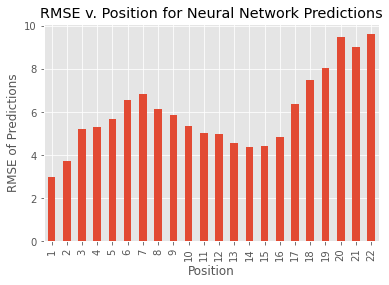

In [30]:
# Visualizes the RMSE of correct guesses for each position
from sklearn.metrics import mean_squared_error

states_list = list(range(10))
df_rmse = pd.DataFrame({'state': states_list})

for positions in range(1,23):
    df_rmse[positions] = np.nan

for i in states_list:
    train_races, test_races, y_train_races, y_test_races = train_test_split( x_races, y_races, test_size=0.3, random_state=i)
    preds = run_models(data, train_races, test_races, 0.00001)
    
    for positions in range(1,23):
        df = preds[preds['positionOrder'] == positions]
        try:    
            rmse = mean_squared_error(df['positionOrder'], df['predictedOrder']) ** .5
        except:
            rmse = np.nan

        df_rmse.loc[i, positions] = rmse

df_ave_rmse = pd.DataFrame({'position': range(1,23)})
df_ave_rmse['aveRMSE'] = np.nan

for i in df_ave_rmse.index:
    position = df_ave_rmse.loc[i,'position']
    ave_rmse = df_rmse[position].mean()
    df_ave_rmse.loc[i,'aveRMSE'] = ave_rmse

df_ave_rmse['aveRMSE'].plot(kind='bar')
plt.xlabel('Position')
plt.xticks(df_ave_rmse.index, df_ave_rmse['position'])
plt.ylabel('RMSE of Predictions')
plt.title('RMSE v. Position for Neural Network Predictions')
plt.show

In [40]:
# Scores the algorithm's guesses for 2021 compared to the BOTG Predictions
df_check = pd.read_csv('f1_archive/botg_prediction_checker.csv')

races_2021 = df_check['raceId']
races_other = []

for races in x_races:
    if races in races_2021:
        pass
    else:
        races_other.append(races)

preds = run_models(data, races_other, races_2021, 0.00001)

botg_preds = df_check.copy()

botg_preds['modelWinner'] = ''
botg_preds['modelDnf1'] = ''
botg_preds['modelRandomPos'] = ''
botg_preds['score'] = 0

for i in botg_preds.index:
    raceId = botg_preds.loc[i,'raceId']
    randomId = botg_preds.loc[i,'randomId']

    winner = preds[(preds['raceId'] == raceId) & (preds['predictedOrder'] == 1)]['driverId'].to_list()[0]
    winner_name = drivers[drivers['driverId'] == winner]['forename'].to_list()[0] + ' ' + drivers[drivers['driverId'] == winner]['surname'].to_list()[0]

    try:
        dnf1 = preds[(preds['raceId'] == raceId) & (preds['predictedOrder'] == 20.0)]['driverId'].to_list()[0]
    except:
        print(raceId)   
    dnf1_name = drivers[drivers['driverId'] == dnf1]['forename'].to_list()[0] + ' ' + drivers[drivers['driverId'] == dnf1]['surname'].to_list()[0]

    randomPos = preds[(preds['raceId'] == raceId) & (preds['driverId'] == randomId)]['predictedOrder'].to_list()[0]

    botg_preds.loc[i,'modelWinner'] = winner_name
    botg_preds.loc[i,'modelDnf1'] = dnf1_name
    botg_preds.loc[i,'modelRandomPos'] = randomPos

    score = 0

    if winner_name == botg_preds.loc[i,'winner']:
        score += 1

    if dnf1_name == botg_preds.loc[i,'dnf1']:
        score += 1

    if randomPos == botg_preds.loc[i,'randomPos']:
        score += 1

    botg_preds.loc[i,'score'] = score

correct = preds[preds['error'] == 0].shape[0]
pct_correct = correct / preds.shape[0]
winners = preds[(preds['error'] == 0) & (preds['positionOrder'] == 1)].shape[0]
pct_winners = winners / preds['raceId'].drop_duplicates().shape[0]
dnf_1s = preds[(preds['error'] == 0) & (preds['positionOrder'] == 20)].shape[0]
pct_dnf_1s = dnf_1s / preds['raceId'].drop_duplicates().shape[0]
points = round((pct_correct * 44) + (pct_winners * 22))

print('Correct Guesses:', correct)
print('Percent Correct:', round(correct / preds.shape[0], 3))
print()
print('Number of Rounds:', preds['raceId'].drop_duplicates().shape[0])
print('Correct Winners:', winners)
print('Percent of Winners Correct:', round(winners / preds['raceId'].drop_duplicates().shape[0], 3))
print('Correct First DNFs:', dnf_1s)
print()
print('The Model Actually Scored:', sum(botg_preds['score']))
botg_preds.head(22)

1073
Correct Guesses: 47
Percent Correct: 0.118

Number of Rounds: 20
Correct Winners: 5
Percent of Winners Correct: 0.25
Correct First DNFs: 2

The Model Actually Scored: 9


,Unnamed: 0,raceId,round,name,botgId,winner,dnf1,randomDriver,randomId,randomPos,modelWinner,modelDnf1,modelRandomPos,score
0,0,1052,1,Bahrain Grand Prix,62,Lewis Hamilton,Nikita Mazepin,Antonio Giovinazzi,841.0,12.0,Lewis Hamilton,Charles Leclerc,18.0,1
1,1,1053,2,Emilia Romagna Grand Prix,63,Max Verstappen,Nicholas Latifi,Sebastian Vettel,20.0,15.0,Carlos Sainz,Sebastian Vettel,20.0,0
2,2,1054,3,Portuguese Grand Prix,64,Lewis Hamilton,Kimi Raikkonen,George Russell,847.0,16.0,Max Verstappen,Esteban Ocon,14.0,0
3,3,1055,4,Spanish Grand Prix,65,Lewis Hamilton,Yuki Tsunoda,Daniel Ricciardo,817.0,6.0,Lewis Hamilton,Lance Stroll,8.0,1
4,4,1056,5,Monaco Grand Prix,66,Max Verstappen,Charles Leclerc,Lando Norris,846.0,3.0,Lewis Hamilton,Yuki Tsunoda,5.0,0
5,5,1057,6,Azerbaijan Grand Prix,67,Sergio Perez,Esteban Ocon,Yuki Tsunoda,852.0,7.0,Lewis Hamilton,Yuki Tsunoda,20.0,0
6,6,1059,7,French Grand Prix,68,Max Verstappen,Nikita Mazepin,Sergio Perez,815.0,3.0,Carlos Sainz,Esteban Ocon,3.0,1
7,7,1058,8,Styrian Grand Prix,69,Max Verstappen,Pierre Gasly,Nikita Mazepin,853.0,18.0,Lewis Hamilton,Lance Stroll,15.0,0
8,8,1060,9,Austrian Grand Prix,70,Max Verstappen,Esteban Ocon,Valtteri Bottas,822.0,2.0,Lewis Hamilton,Esteban Ocon,4.0,1
9,9,1061,10,British Grand Prix,71,Lewis Hamilton,Max Verstappen,Lewis Hamilton,1.0,1.0,Lewis Hamilton,Sebastian Vettel,1.0,2


The RMSE for Total Points using the Baseline is: 34.49827462904417


<function matplotlib.pyplot.show(close=None, block=None)>

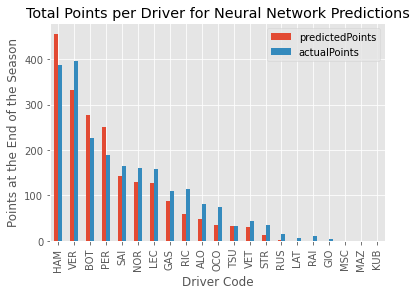

In [41]:
# Predicts the number of points that each driver will get in the 2021 season, and finds the RMSE
pos_to_points = {1:25, 2:18, 3:15, 4:12, 5:10, 6:8, 7:6, 8:4, 9:2, 10:1,
                 11:0, 12:0, 13:0, 14:0, 15:0, 16:0, 17:0, 18:0, 19:0, 20:0,
                 21:0, 22:0, 23:0, 24:0, 25:0, 26:0, 27:0, 28:0, 29:0, 30:0,
                 31:0, 53:0, 68:0, 86:0}

preds = run_models(data, races_other, races_2021, 0.00001)

points_df = preds[['raceId', 'driverId', 'code', 'positionOrder', 'predictedOrder']].copy()
points_df = points_df[points_df['raceId'].isin(races_2021)]
points_df['points'] = np.nan

for i in points_df.index:
    points = pos_to_points[int(points_df.loc[i,'predictedOrder'])]
    points_df.loc[i,'points'] = points

final_points = pd.DataFrame({'driverId': points_df['driverId'].drop_duplicates()})
final_points.reset_index(drop=True, inplace=True)

final_points['code'] = ''
final_points['predictedPoints'] = 0
final_points['actualPoints'] = 0

for i,drivers in enumerate(final_points['driverId']):
    predicted_points = points_df[points_df['driverId'] == drivers]['points'].sum()
    actual_points = wdc[(wdc['raceId'] == 1073) & (wdc['driverId'] == drivers)]['points'].to_list()[0]
    code = points_df[points_df['driverId'] == drivers]['code'].to_list()[0]
    final_points.loc[i,'code'] = code
    final_points.loc[i,'predictedPoints'] = predicted_points
    final_points.loc[i,'actualPoints'] = actual_points

final_points.sort_values(by='predictedPoints', ascending=False, inplace=True)
final_points.reset_index(drop=True, inplace=True)

print('The RMSE for Total Points using the Baseline is:', mean_squared_error(final_points['actualPoints'], final_points['predictedPoints']) ** .5)

final_points[['predictedPoints', 'actualPoints']].plot(kind='bar')
plt.xlabel('Driver Code')
plt.xticks(final_points.index, final_points['code'])
plt.ylabel('Points at the End of the Season')
plt.title('Total Points per Driver for Neural Network Predictions')
plt.show

### Output Visualization

In [36]:
# Generates train test splits, and scores the models they produce
train_races, test_races, y_train_races, y_test_races = train_test_split( x_races, y_races, test_size=0.3, random_state=1)

preds = run_models(data, train_races, test_races, 0.00001)

correct = preds[preds['error'] == 0].shape[0]
pct_correct = correct / preds.shape[0]
winners = preds[(preds['error'] == 0) & (preds['positionOrder'] == 1)].shape[0]
pct_winners = winners / preds['raceId'].drop_duplicates().shape[0]
dnf_1s = preds[(preds['error'] == 0) & (preds['positionOrder'] == 20)].shape[0]
pct_dnf_1s = dnf_1s / preds['raceId'].drop_duplicates().shape[0]
points = round((pct_correct * 44) + (pct_winners * 22))

print('Correct Guesses:', correct)
print('Percent Correct:', round(correct / preds.shape[0], 3))
print()
print('Number of Rounds:', preds['raceId'].drop_duplicates().shape[0])
print('Correct Winners:', winners)
print('Percent of Winners Correct:', round(winners / preds['raceId'].drop_duplicates().shape[0], 3))
print('Correct First DNFs:', dnf_1s)
print()
print('Projected Number of Points:', points, 'or maybe even', round(points * 5/3))
print()
print(round(pct_correct, 3), '/', round(pct_winners, 3), '/', round(pct_dnf_1s, 3), '/', points)


preds[preds['error'] == 0]

Correct Guesses: 124
Percent Correct: 0.128

Number of Rounds: 48
Correct Winners: 19
Percent of Winners Correct: 0.396
Correct First DNFs: 0

Projected Number of Points: 14 or maybe even 23

0.128 / 0.396 / 0.0 / 14


,resultId,raceId,driverId,code,constructorId,positionOrder,predictedOrder,error
2727,24866,1043,1,HAM,131,1,1.0,0.0
2707,24846,1042,1,HAM,131,1,1.0,0.0
2107,24243,1012,1,HAM,131,1,1.0,0.0
1947,24083,1004,1,HAM,131,1,1.0,0.0
1791,23926,996,20,VET,6,5,5.0,0.0
...,...,...,...,...,...,...,...,...
657,22788,939,154,GRO,208,13,13.0,0.0
493,22624,930,832,SAI,5,9,9.0,0.0
2573,24712,1035,807,HUL,211,7,7.0,0.0
1754,23889,994,807,HUL,4,8,8.0,0.0


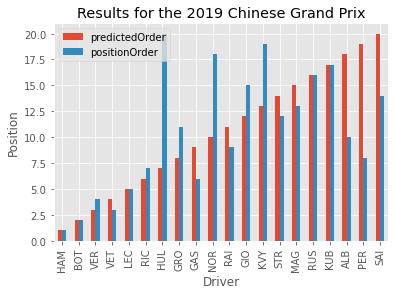

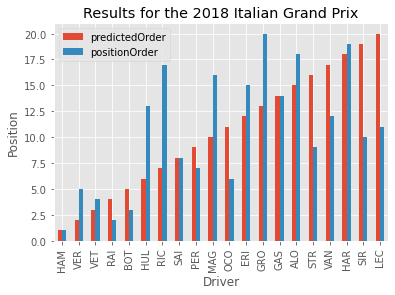

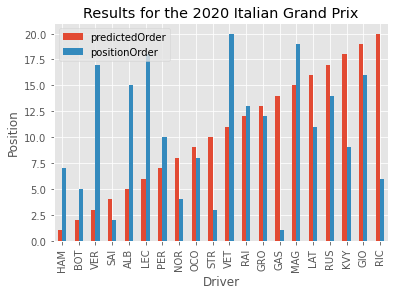

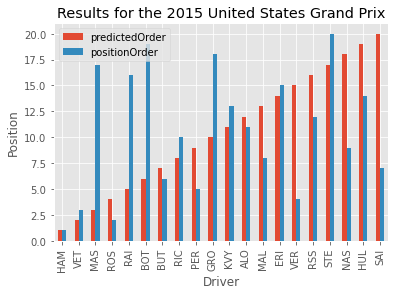

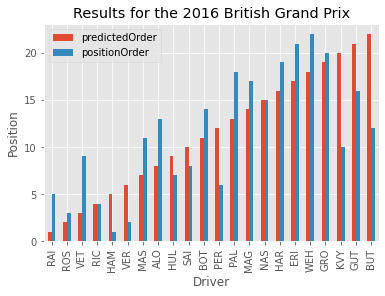

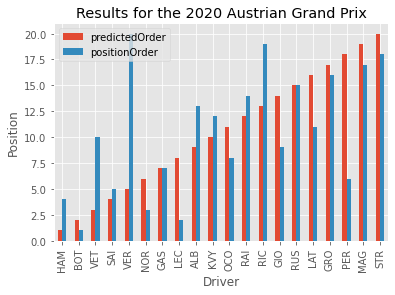

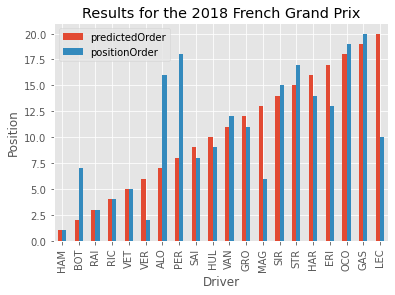

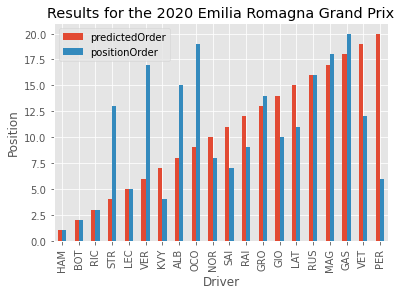

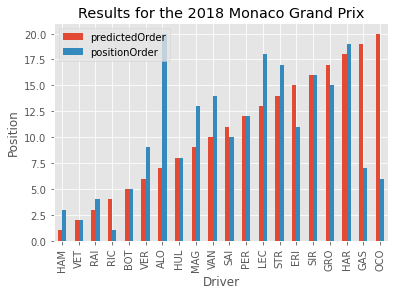

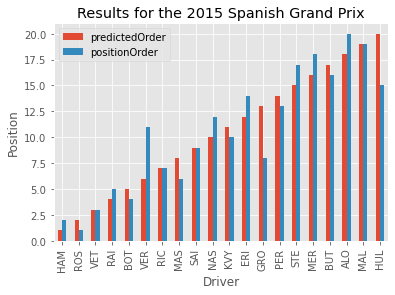

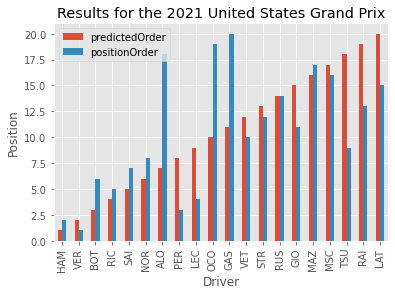

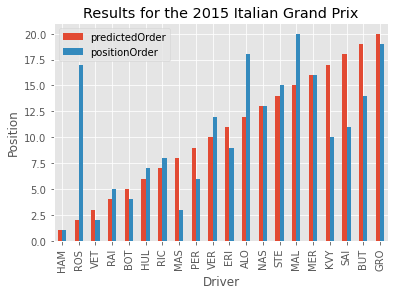

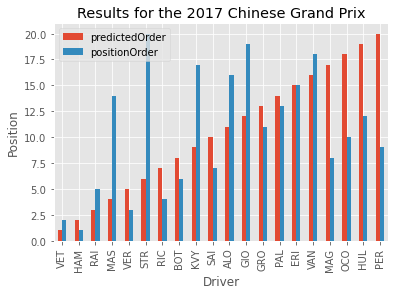

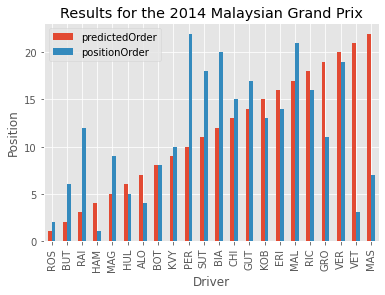

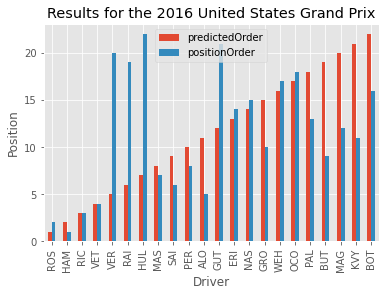

In [39]:
# Defines a function that displays the results
def plot_results(data, id):
    data = data[data['raceId'] == id]
    data = data.sort_values(by='predictedOrder', ascending=True).set_index('code')
    data = data[['predictedOrder', 'positionOrder']]
    data.plot(kind='bar')

    race = str(races[races['raceId'] == id]['name'].to_list()[0])
    year = str(races[races['raceId'] == id]['year'].to_list()[0])
    title = 'Results for the ' + year + ' ' + race
    plt.title(title)
    plt.xlabel('Driver')
    plt.ylabel('Position')

for ids in test_races[:15]:
    plot_results(preds, ids)
